In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

In [60]:
data = pd.read_csv("Alcohol_Sales.csv",index_col='DATE',parse_dates=True)
data.columns = ['Sales']

In [61]:
data

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


In [6]:
country = 'US'
data = data[data["Country/Region"] == country]
data = pd.DataFrame(data[data.columns[4:]].sum(),columns=["confirmed"])
data.index = pd.to_datetime(data.index,format='%m/%d/%y')

In [62]:
data

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221
...,...
2018-09-01,12396
2018-10-01,13914
2018-11-01,14174


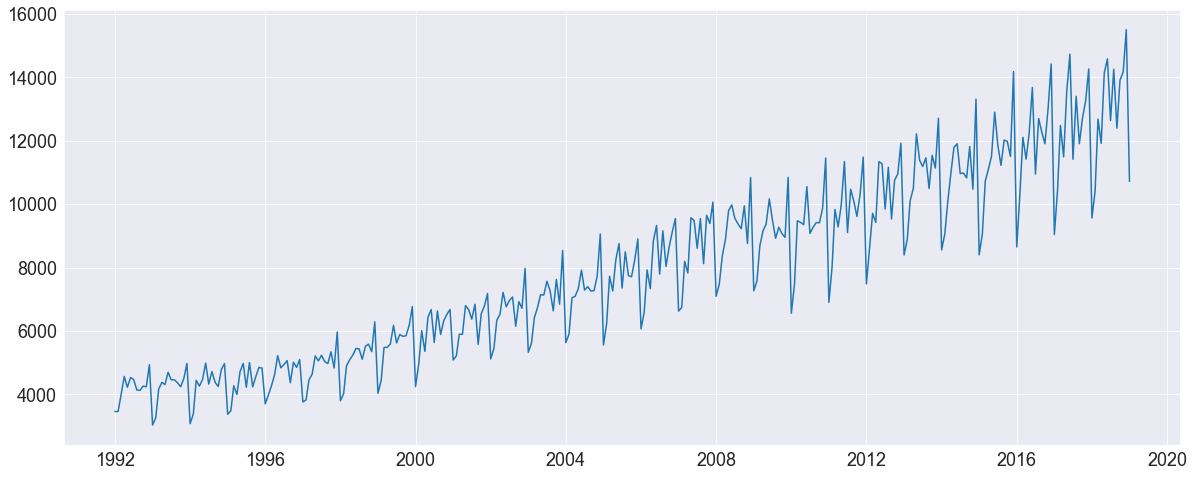

In [63]:
plt.plot(data['Sales'])
plt.show()

In [209]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [211]:
results = seasonal_decompose(data['Sales'])

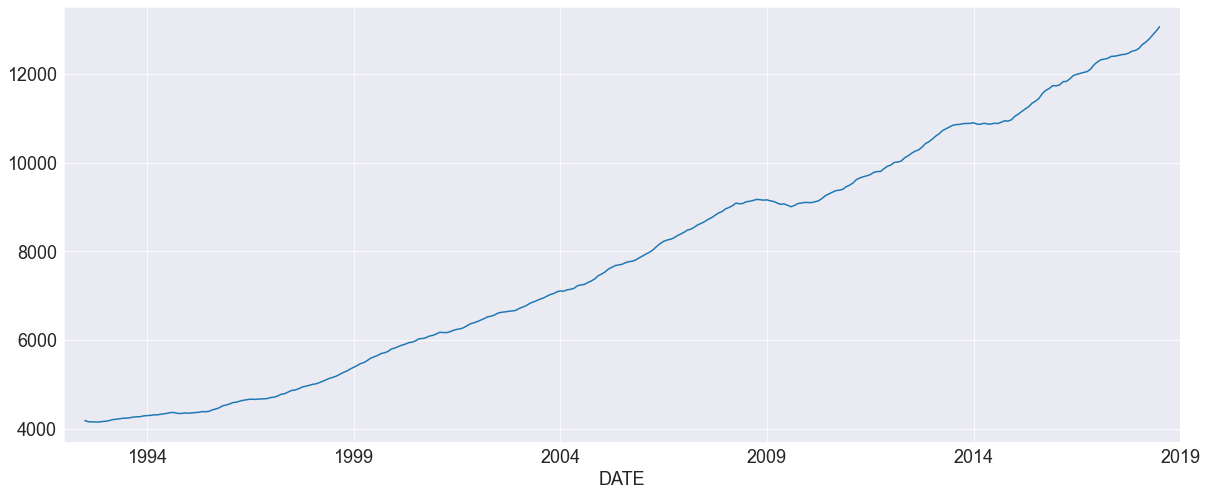

In [213]:
results.trend.plot()
plt.show()

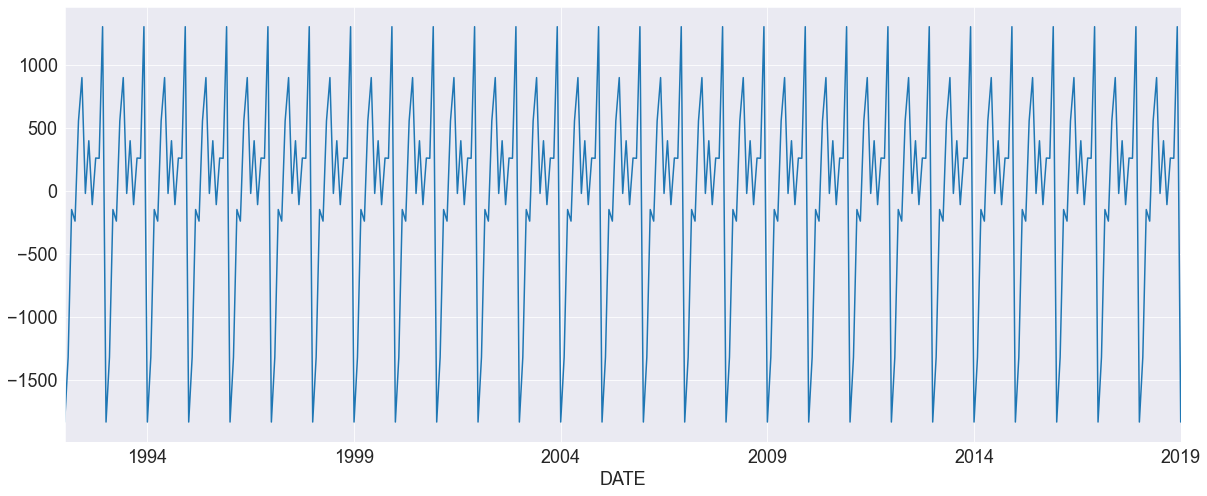

In [214]:
results.seasonal.plot()

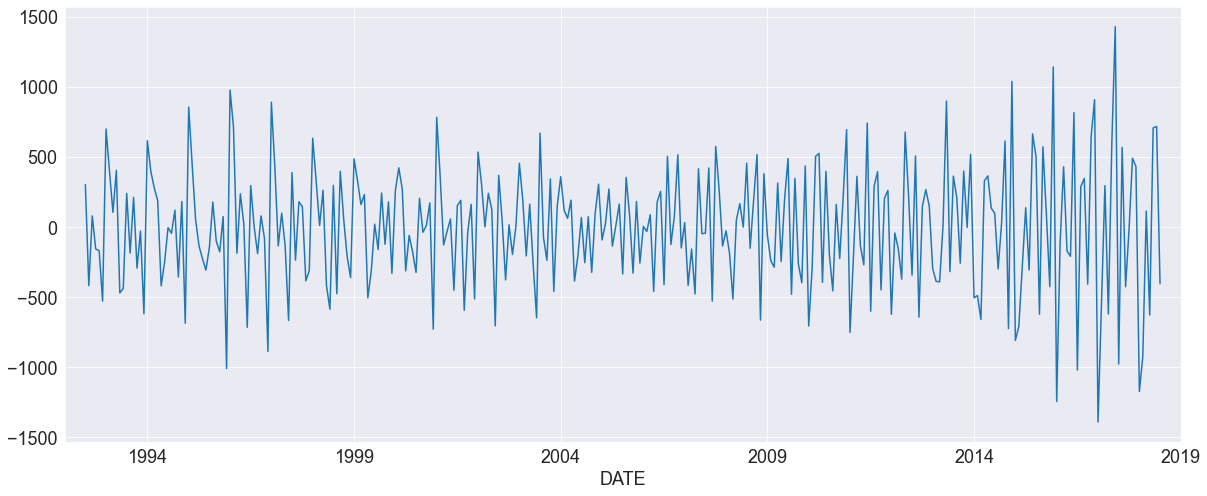

In [215]:
results.resid.plot()

In [177]:
x = len(data)-36

train = data.iloc[:x]
test = data.iloc[x:]

In [178]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train) 

MinMaxScaler()

In [221]:
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

ValueError: X has 2 features, but MinMaxScaler is expecting 1 features as input.

In [224]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Bidirectional

seq_size = 12
n_features = 1 
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) 
print("Total number of samples in the generated data = ", len(train_generator)) 

x,y = train_generator[10]  

test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) 
print("Total number of samples in the generated data = ", len(test_generator)) 

x,y = test_generator[0]

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

# define model
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(seq_size, n_features))))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

Total number of samples in the original training data =  289
Total number of samples in the generated data =  277
Total number of samples in the original training data =  36
Total number of samples in the generated data =  24


In [225]:
history = model.fit(train_generator, 
                    validation_data=test_generator, 
                    epochs=50)

Epoch 1/50
277/277 [==============================] - 3s 5ms/step - loss: 0.0169 - val_loss: 0.0220
Epoch 2/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0075 - val_loss: 0.0253
Epoch 3/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0070 - val_loss: 0.0150
Epoch 4/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0057 - val_loss: 0.0108
Epoch 5/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 6/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0035 - val_loss: 0.0105
Epoch 7/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0026 - val_loss: 0.0023
Epoch 8/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 9/50
277/277 [==============================] - 1s 4ms/step - loss: 0.0020 - val_loss: 0.0024
Epoch 10/50
277/277 [==============================] - 1s 5ms/step - loss: 0.0017 - val_loss: 0.0074

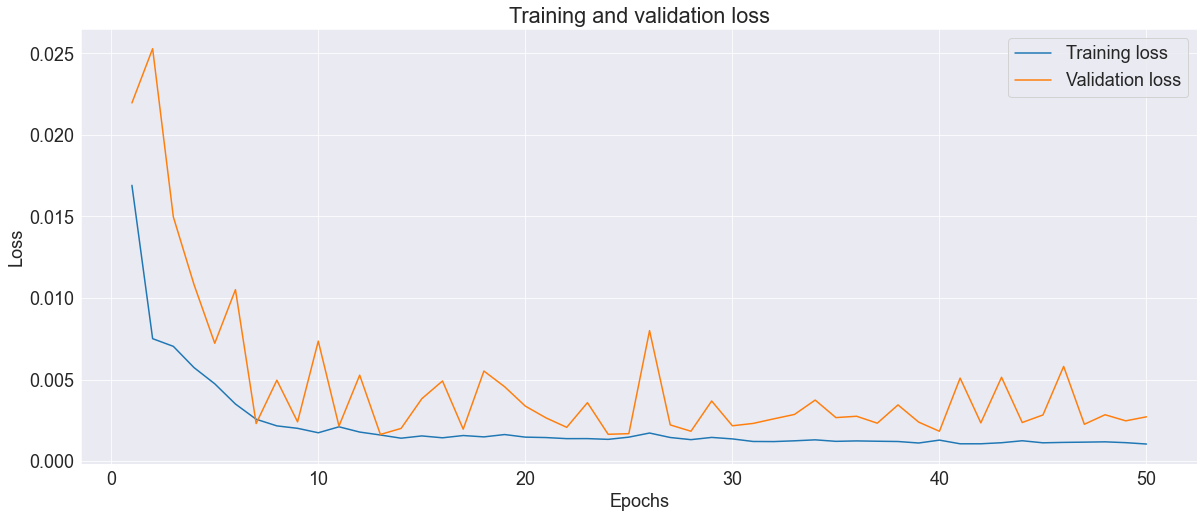

In [226]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

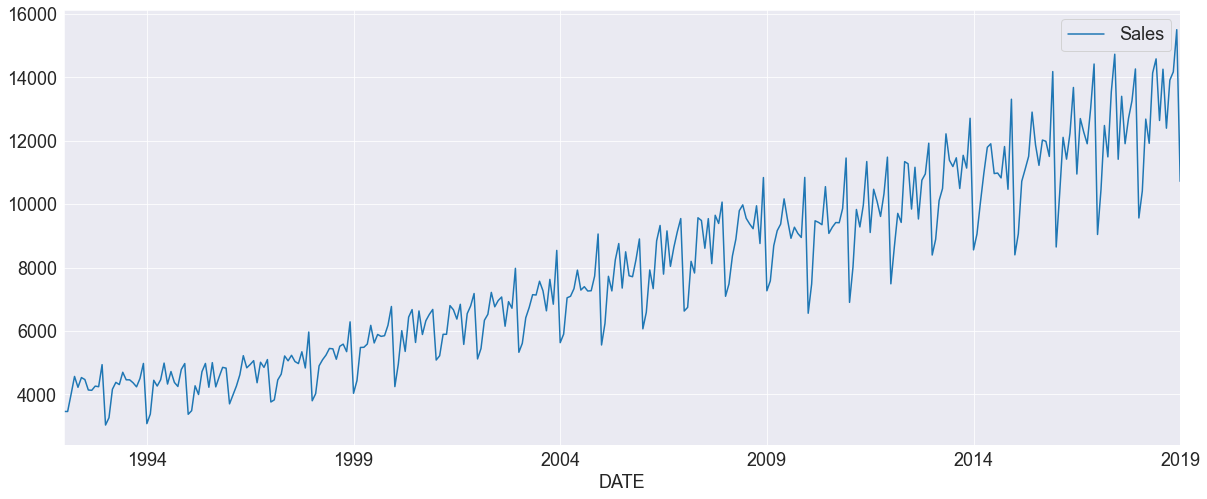

In [227]:
data.plot()
plt.show()

In [228]:
first_eval_batch = train_scaled[-seq_size:]

In [229]:
first_eval_batch.shape

(12, 1)

In [230]:
current_batch = first_eval_batch.reshape((1, seq_size, 1))

In [231]:
current_batch.shape

(1, 12, 1)

In [232]:
model.predict(current_batch)

array([[0.5673286]], dtype=float32)

In [233]:
test_predictions = []

first_eval_batch = train_scaled[-seq_size:]
current_batch = first_eval_batch.reshape((1, seq_size, 1))

for i in range(len(test_scaled)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [234]:
test_predictions

[array([0.5673286], dtype=float32),
 array([0.700305], dtype=float32),
 array([0.71794724], dtype=float32),
 array([0.7885284], dtype=float32),
 array([0.8876293], dtype=float32),
 array([0.79700905], dtype=float32),
 array([0.7775777], dtype=float32),
 array([0.8194968], dtype=float32),
 array([0.7909017], dtype=float32),
 array([0.7957811], dtype=float32),
 array([1.0023404], dtype=float32),
 array([0.5163746], dtype=float32),
 array([0.5931035], dtype=float32),
 array([0.7079867], dtype=float32),
 array([0.71585363], dtype=float32),
 array([0.8079294], dtype=float32),
 array([0.89083964], dtype=float32),
 array([0.8034592], dtype=float32),
 array([0.81076276], dtype=float32),
 array([0.8331598], dtype=float32),
 array([0.80044943], dtype=float32),
 array([0.8191937], dtype=float32),
 array([1.0045652], dtype=float32),
 array([0.53208816], dtype=float32),
 array([0.6197391], dtype=float32),
 array([0.7156946], dtype=float32),
 array([0.7179629], dtype=float32),
 array([0.8212675], dt

In [235]:
predictions = scaler.inverse_transform(test_predictions)

In [236]:
test['predicted'] = predictions

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [237]:
test_scaled.shape

(36, 1)

In [238]:
test_predictions

[array([0.5673286], dtype=float32),
 array([0.700305], dtype=float32),
 array([0.71794724], dtype=float32),
 array([0.7885284], dtype=float32),
 array([0.8876293], dtype=float32),
 array([0.79700905], dtype=float32),
 array([0.7775777], dtype=float32),
 array([0.8194968], dtype=float32),
 array([0.7909017], dtype=float32),
 array([0.7957811], dtype=float32),
 array([1.0023404], dtype=float32),
 array([0.5163746], dtype=float32),
 array([0.5931035], dtype=float32),
 array([0.7079867], dtype=float32),
 array([0.71585363], dtype=float32),
 array([0.8079294], dtype=float32),
 array([0.89083964], dtype=float32),
 array([0.8034592], dtype=float32),
 array([0.81076276], dtype=float32),
 array([0.8331598], dtype=float32),
 array([0.80044943], dtype=float32),
 array([0.8191937], dtype=float32),
 array([1.0045652], dtype=float32),
 array([0.53208816], dtype=float32),
 array([0.6197391], dtype=float32),
 array([0.7156946], dtype=float32),
 array([0.7179629], dtype=float32),
 array([0.8212675], dt

In [239]:
test

,Sales,predicted
DATE,,
2016-02-01,10321,9357.848238
2016-03-01,12107,10840.801193
2016-04-01,11420,11037.547672
2016-05-01,12238,11824.668525
2016-06-01,13681,12929.841625
2016-07-01,10950,11919.244935
2016-08-01,12700,11702.546491
2016-09-01,12272,12170.028430
2016-10-01,11905,11851.135987


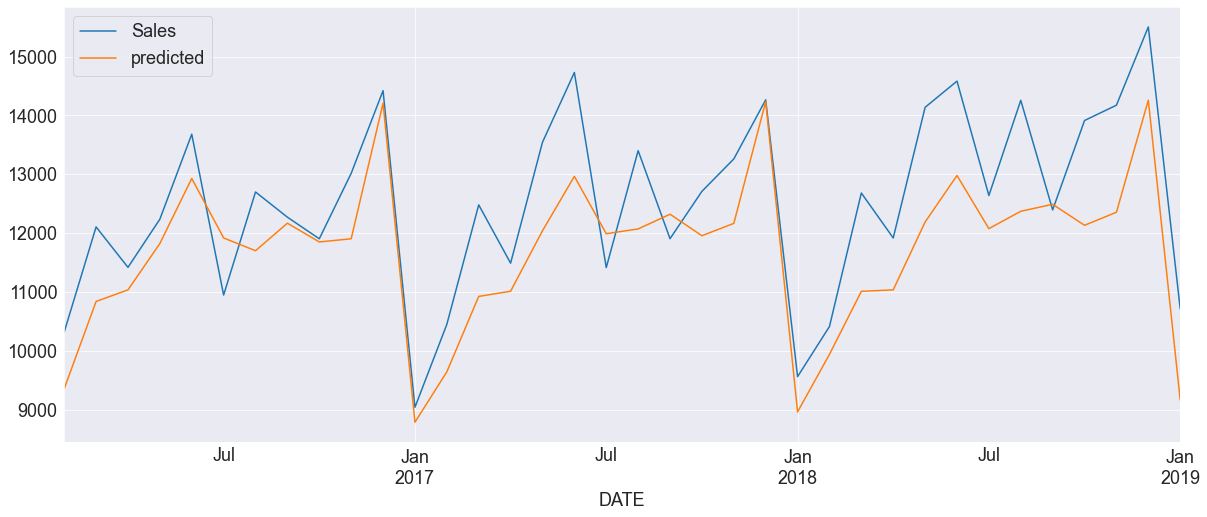

In [240]:
test.plot()